In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import os

In [2]:
!pip install XlsxWriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 2.8 MB/s eta 0:00:00


In [3]:
os.listdir()

['.config',
 'all_fumarate.csv',
 'all_coa.csv',
 'all_alanine.csv',
 'all_glutamate.csv',
 'all_NADH.csv',
 'all_glyoxylate.csv',
 'all_atp.csv',
 'all_valine.csv',
 'LCMS_Standards.xlsx',
 'all_succinate.csv',
 'all_hydroxyglutarate.csv',
 'all_lysine.csv',
 'all_oxobutanoate.csv',
 'all_malate.csv',
 'all_glycine.csv',
 'all_aspartate.csv',
 'all_citrate.csv',
 'all_serine.csv',
 'all_pyruvate.csv',
 'all_acetylcoa.csv',
 'sample_data']

In [156]:
data_files = os.listdir()

peaks_df = {}
for file in data_files:
    if '.csv' in file:
        df = pd.read_csv(file)
        df['Labels'] = df.iloc[:,0].apply(lambda x: x.split('\\')[-1][:-3])
        df = df.sort_values('Labels')
        df_simple = df[['Labels','Area']]
        peaks_df[file.split('.')[0].split('_')[-1]] = df_simple


In [157]:
all_samples = []
all_samples= [s for s in np.unique(sum([list(v['Labels']) for v in peaks_df.values()],[])) if not np.any([n  in s for n in ['sds','std']])]
all_metabolites = list(peaks_df.keys())

In [395]:
compiled = pd.DataFrame(index = all_samples, columns = all_metabolites, dtype=float)
for s in all_samples:
    for k,v in peaks_df.items():
        if s in v['Labels'].values:
            compiled.loc[s][k] = v[v['Labels'] == s]['Area'].values[0]

In [396]:
compiled['sample'] = [x[:-2].replace('-','_') if (np.any([x[-2:].replace('-','_')==y for y in ['_1','_2','_3']]) and x[-3]!='x') else x.replace('-','_') for x in list(compiled.index)]
compiled['sample'] = ['zero' if x=='zero1' else x for x in compiled['sample']]
compiled['sample'] = ['zero' if x=='zero2' else x for x in compiled['sample']]
compiled['sample'] = ['zero' if x=='zero3' else x for x in compiled['sample']]

In [160]:
import re
import pandas as pd
# get standards and parse equations
standards = pd.read_excel('LCMS_Standards.xlsx', engine='openpyxl')

# get mesurement columns
# measurement_index = [np.any([slabel in dlabel for slabel in standards.iloc[:,0].values]) for dlabel in list(data.iloc[0,1:].keys())] # will only recognize label if in standards

peak_to_concentration = {}
for row in standards.iterrows():
    equation = row[1]['Equation']
    # Use regular expressions to extract the slope and y-intercept
    match_pos = re.search(r'Y = (\d+)X \+ (\d+)', equation.replace('*',''))
    match_neg = re.search(r'Y = (\d+)X \- (\d+)', equation.replace('*',''))

    if match_pos:
        slope = int(match_pos.group(1))
        y_intercept = int(match_pos.group(2))

    if match_neg:
        slope = int(match_neg.group(1))
        y_intercept = -int(match_neg.group(2))

    del match_pos, match_neg
    peak_to_concentration[row[1]['Metabolite']] = lambda peak_area, y=y_intercept, s=slope: (peak_area-y)/s # what are the units?

In [397]:
def not_negative(x):
    if x < 0:
        x = np.nan
    return x

true_empty = compiled.drop(columns=['sample'], inplace=False).isna()
true_empty_mean = compiled.groupby('sample').mean().isna()

measurements = compiled[[m for m in list(peak_to_concentration.keys()) if m in compiled.columns]]
measurements = pd.concat([measurements[[m]].apply(lambda x: peak_to_concentration[m](x)) for m in measurements.columns],axis = 1)
measurements = measurements.applymap(not_negative)
measurements['sample'] = [x[:-2].replace('-','_') if (np.any([x[-2:].replace('-','_')==y for y in ['_1','_2','_3']]) and x[-3]!='x') else x.replace('-','_') for x in list(measurements.index)]
measurements['sample'] = ['zero' if x=='zero1' else x for x in measurements['sample']]
measurements['sample'] = ['zero' if x=='zero2' else x for x in measurements['sample']]
measurements['sample'] = ['zero' if x=='zero3' else x for x in measurements['sample']]
measurements['glycine'] = measurements['glycine'].apply(lambda x: x/10)

true_stds = measurements.groupby('sample').std()
true_means = measurements.groupby('sample').mean()

sample = measurements['sample']
measurements = measurements.drop(columns=['sample'])
for m in measurements.columns:
    mins = measurements[measurements>0].min()[m]
    measurements[m].fillna(mins/10,inplace=True)
    measurements[m][true_empty[m]] = mins/100
measurements['sample'] = sample

means = measurements.groupby('sample').mean()

<ipython-input-397-f68e23c65adb>:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  measurements = measurements.applymap(not_negative)


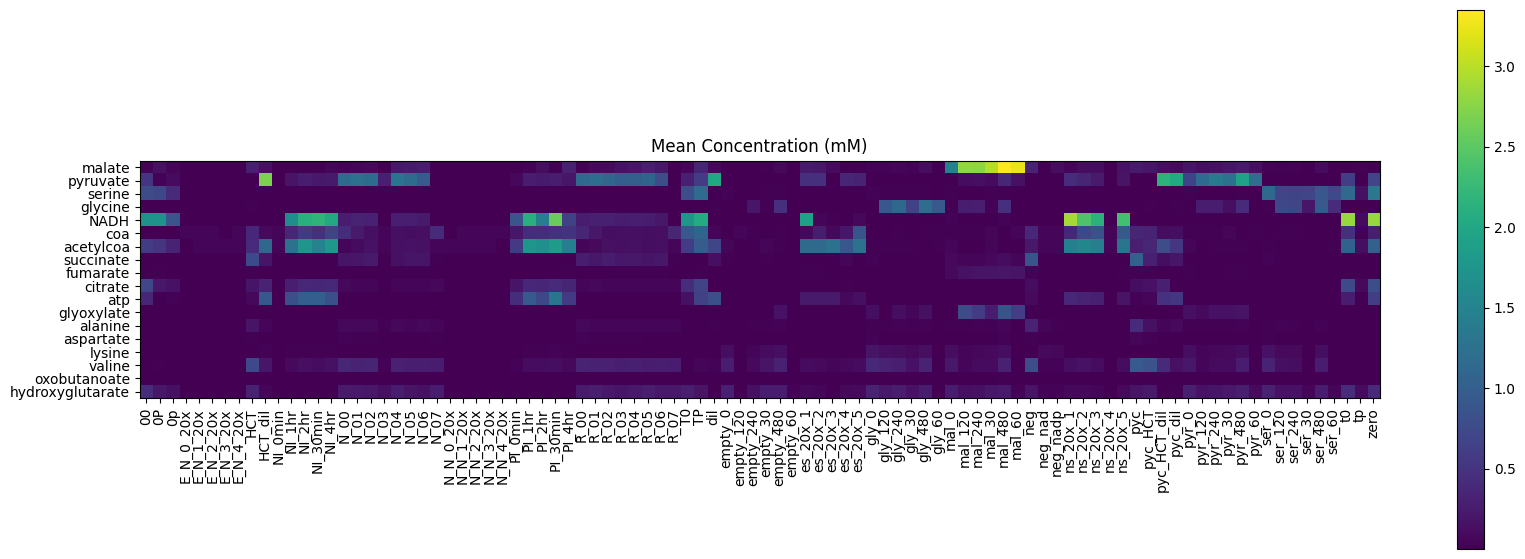

In [398]:
plt.figure(figsize=(20,7))
plt.imshow((means.T))
plt.yticks(range(len(means.columns)),means.columns, rotation=0);
plt.xticks(range(len(means)),means.index, rotation=90);
plt.title('Mean Concentration (mM)');
plt.colorbar()

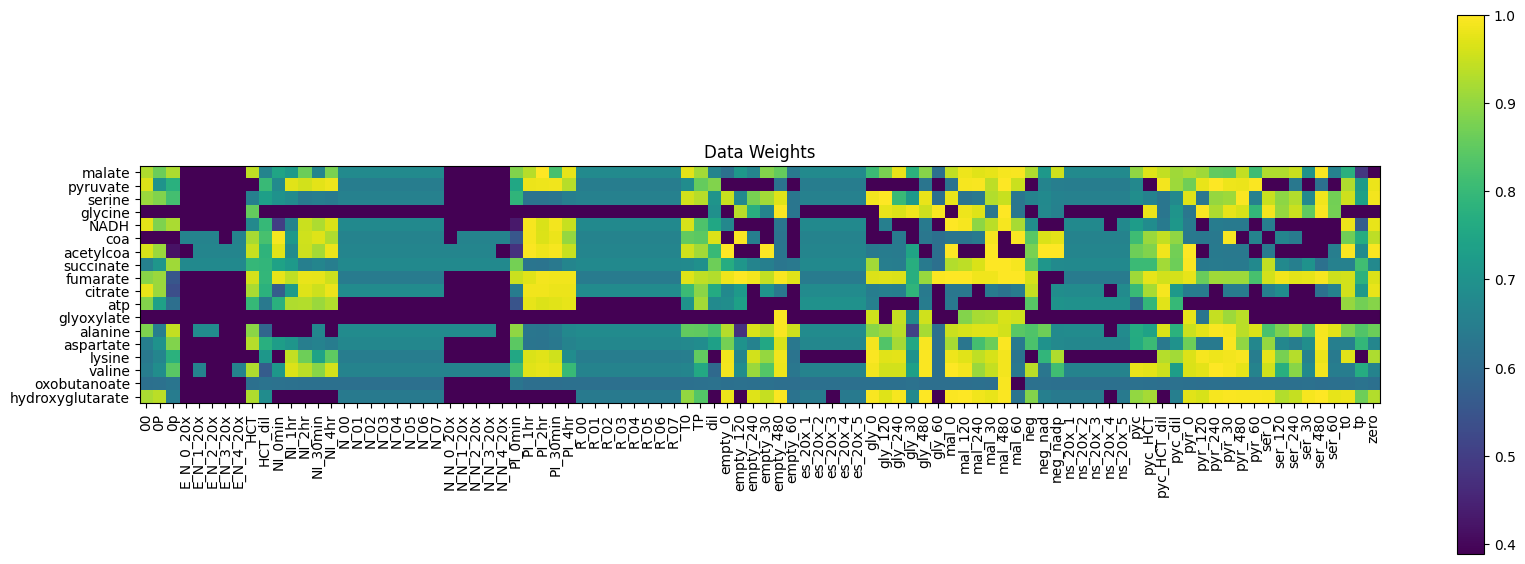

In [399]:
true_error = (true_stds/true_means)
error = (true_stds/true_means)
error = (error.T.mean(0).fillna(error.T.mean(0).mean()).to_numpy()[np.newaxis].T*(error).T.mean(1).fillna(error.T.mean(1).mean()).to_numpy()[np.newaxis])
error = pd.DataFrame(error,dtype=float)
n_error = (error.max().max() - error) / (error.max().max() - error.min().min())
n_error[n_error == 0] = np.max(n_error)

true_error[true_error.isnull()] = n_error.values
n_error = (true_error.max().max() - true_error+1) / (true_error.max().max() - true_error.min().min()+1)

n_error[true_empty_mean] = n_error.min().min()
plt.figure(figsize=(20,7))
plt.imshow(n_error.T)
plt.colorbar()
plt.title('Data Weights')
plt.yticks(range(len(means.columns)),means.columns, rotation=0);
plt.xticks(range(len(means)),means.index, rotation=90);

In [400]:
means.to_csv('data.csv')
n_error.to_csv('data_weights.csv')